# Transfer Learning Experiments

* model_1 : Feature extraction transfer learning with 1% of the training data with data augmentation
* model_2 : Use feature extraction transfer learning with 10% of data
* model_3 : Use fine tuning transfer learning on 10% of training data with data augmentation
* model_4: Use fine-tuning transfer learning on 100% of the training data with data augmentation

In [4]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-04-27 10:24:18--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2024-04-27 10:24:18 (17.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [5]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Getting data and laoding it

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

--2024-04-25 17:01:27--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.135.207, 74.125.195.207, 74.125.142.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.135.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.1’

10_food_classes_1_p 100%[===================>] 127.42M   190MB/s    in 0.7s    

2024-04-25 17:01:27 (190 MB/s) - ‘10_food_classes_1_percent.zip.1’ saved [133612354/133612354]



In [ ]:
unzip_data("10_food_classes_1_percent.zip")

In [ ]:
# create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [ ]:
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There a

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd

In [ ]:
# setup data loaders
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_1_percent,
    image_size = (224,224),
    batch_size = 32,
    label_mode = "categorical"
)

Found 70 files belonging to 10 classes.


In [ ]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size = (224, 224),
    batch_size = 32,
    label_mode = "categorical"
)

Found 2500 files belonging to 10 classes.


## Augmentation

In [ ]:
# adding augmentation right into the model (tf.keras.layers.experimental.preprocessing())

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# create data augmentation stage with horizontal flipping, rotations, zooms, etc

data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomHeight(0.2),
    # preprocessing.Rescale(1/255.),

],  name = "data_augmentation")

(-0.5, 511.5, 441.5, -0.5)

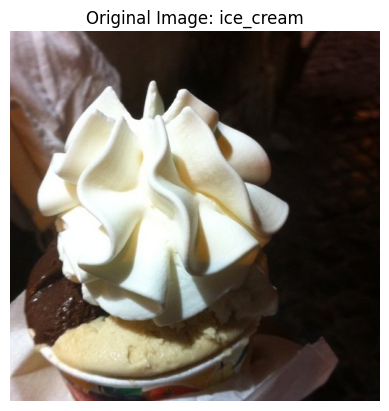

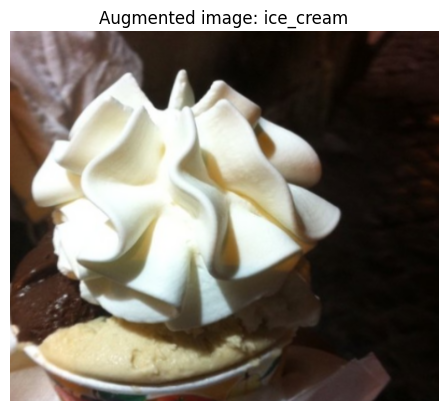

In [ ]:
# visualize our data augmentation layer.

# view a random image and its augmented image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class

random_image = random.choice(os.listdir(target_dir))

random_image_path = target_dir + "/" + random_image

image = mpimg.imread(random_image_path)
plt.imshow(image)
plt.axis("off")
plt.title(f"Original Image: {target_class}")


# Augment this image
augmented_image = data_augmentation(image)
plt.figure()
plt.imshow(augmented_image/255.)
plt.title(f"Augmented image: {target_class}")
plt.axis("off")

# Building Model 1

In [25]:
# setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape = input_shape, name = "input_layer")

# add in data augmentation layer
x = data_augmentation(inputs)

# give base model the inputs (after augmentation) and don't train it
x = base_model(x, training = False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name = "global_average_pooling2d")(x)

# put a dense layer on as the output
outputs = layers.Dense(10, activation = "softmax", name = "output_layer")(x)

# make a model
model_1 = keras.Model(inputs, outputs)

# compile model
model_1.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

# fit the model
history_1 = model_1.fit(
    train_data_1_percent,
    epochs = 1,
    steps_per_epoch = len(train_data_1_percent),
    validation_data = test_data,
    validation_steps = int(0.25 * len(test_data))
)

NameError: name 'keras' is not defined

# Model2: Feature Extraction transfer learning model with 10percent of data and data augmentation.

In [1]:
# Get 10 percent of data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2024-04-27 10:23:50--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 74.125.137.207, 142.250.101.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   107MB/s    in 1.5s    

2024-04-27 10:23:51 (107 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [6]:
unzip_data("10_food_classes_10_percent.zip")

In [7]:
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [9]:
# Set data inputs
import tensorflow as tf
IMG_SHAPE = (224, 224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode = "categorical",
    image_size = IMG_SHAPE
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size = IMG_SHAPE,
    label_mode = "categorical"
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [12]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2)
], name = "data_augmentation")

# setup the input shape to out model
input_shape = (224, 224, 3)

# create a frozen base model ( also called the backbone )
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# create the inputs and outputs ( including the layers in between )

inputs = layers.Input(shape = input_shape, name = "input_layer")
x = data_augmentation(inputs)
x = base_model(x, training = False)

x = layers.GlobalAveragePooling2D(name = "global_average_pool2d")(x)

outputs = layers.Dense(10, activation = "softmax", name = "output_layer")(x)

model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(
    loss = "CategoricalCrossentropy",
    optimizer = "Adam",
    metrics = ["accuracy"]
)

In [13]:
model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pool2d (Glo  (None, 1280)              0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                             

## Creating a Model CheckPoint to save our model's weight during training
> save our model as it trains so we can stop training if needed and come back to continue where we left. Used when the training takes long to complete.

In [14]:
# set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# create a model checkpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path,
    save_weights_only = True,
    save_best_only = False,
    save_freq = "epoch", # save every epoch
    verbose = 1
)

In [15]:
# fit the model2 saving checkpoint every epoch

history_2 = model_2.fit(
    train_data_10_percent,
    epochs = 5,
    steps_per_epoch = len(train_data_10_percent),
    validation_data = test_data,
    validation_steps = int(0.25 * len(test_data)),
    callbacks = [checkpoint_callback]
)

Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0224 - accuracy: 0.3280
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 38s 1s/step - loss: 2.0224 - accuracy: 0.3280 - val_loss: 1.4416 - val_accuracy: 0.6727
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3413 - accuracy: 0.6840
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 19s 788ms/step - loss: 1.3413 - accuracy: 0.6840 - val_loss: 0.9785 - val_accuracy: 0.8043
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9928 - accuracy: 0.7867
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 17s 696ms/step - loss: 0.9928 - accuracy: 0.7867 - val_loss: 0.7806 - val_accuracy: 0.8355
Epoch 4/5
24/24 [==============================] - ETA: 0s - loss: 0.8408 - accuracy: 0.798

In [16]:
model_2.evaluate(test_data)

79/79 [==============================] - 9s 103ms/step - loss: 0.6219 - accuracy: 0.8452


[0.621871829032898, 0.8452000021934509]

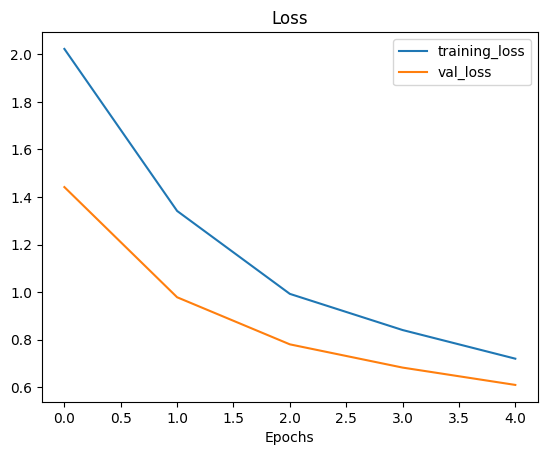

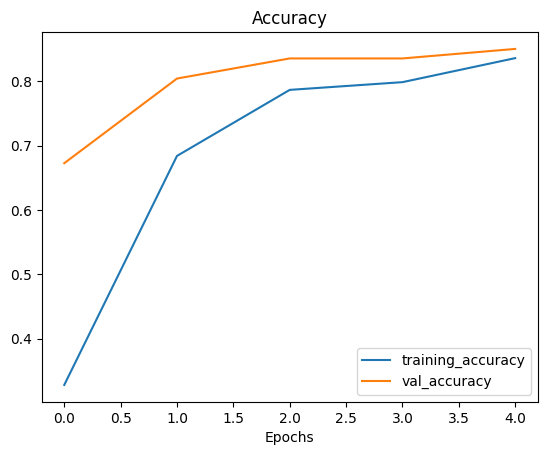

In [17]:
plot_loss_curves(history_2)

# Loading saved weights

In [18]:
# loading in from checkpointed weights returns a model to specific checkpt.

model_2.load_weights(checkpoint_path)

In [19]:
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 6s 65ms/step - loss: 0.6219 - accuracy: 0.8452


# Model3: Fine Tuning our existing model on 10 percent data

* Fine Tuning works better after training feature extraction model for a few epochs with large amounts of custom data.

In [20]:
# model3 is model2 finetuned for further epochs

model_2.layers

In [22]:
# are these layers trainable ?

for layer in model_2.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 False
global_average_pool2d True
output_layer True


In [23]:
# what layers in efficientnet are trainable
for index, layer in enumerate(model_2.layers[2].layers):
  print(index, layer.name, layer.trainable)

0 input_2 False
1 rescaling_2 False
2 normalization_1 False
3 rescaling_3 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [24]:
# unfreeze some layers before training model_3 so make the trainable attribut to True to some of the layer we want to train

print(len(model_2.layers[2].trainable_variables))

0


In [26]:
# To begin fine tuning let set the last 10 layers of our base model trainable to true:

base_model.trainable = True

for layer in base_model.layers[:-10]:
  layer.trainable = False

In [30]:
for layer in base_model.layers:
  print(layer.name, layer.trainable)

input_3 False
rescaling_4 False
normalization_2 False
rescaling_5 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_

In [33]:
model_2.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(lr = 0.0001), # when fine tuning lower the learning rate by 10 percent
    metrics = ['accuracy']
)

In [34]:
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_2 False
1 rescaling_2 False
2 normalization_1 False
3 rescaling_3 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [37]:
len(model_2.trainable_variables)

2